In [131]:
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from itertools import combinations
import time
import pandas as pd

In [132]:
#function that transforms cv.keypoints  in the form of  [[x1,y1], [x2,y2], ...]
def kp_to_list(keypoints):
    point_list = [ [int(kp.pt[0]), int(kp.pt[1])] for kp in keypoints ]
    return point_list

In [133]:
# implementation for 3 of the feature extraction method in one function
def Feature_Extraction(sub_image, method_type, plot=False):
    
    gray = cv2.cvtColor(sub_image, cv2.COLOR_BGR2GRAY)
    method = None
    
    if method_type == 'SURF':
        method = cv2.xfeatures2d.SURF_create()
    if method_type == 'ORB':
        method = cv2.ORB_create()
    if method_type == 'SIFT':
        method = cv2.xfeatures2d.SIFT_create()

    keypoints, descriptors = method.detectAndCompute(gray, None)

    sub_image_with_keypoints = cv2.drawKeypoints(sub_image, keypoints, None)

    if plot:
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(cv2.cvtColor(sub_image_with_keypoints, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(method_type)
        plt.show()

    
    return keypoints, descriptors


In [134]:
print(cv2.__version__)

3.4.2


In [135]:
# get sub images path in a folder
folder_path = "dataset/v_bird"  
image_paths = []
search_path = os.path.join(folder_path, "*.png")
image_paths.extend(glob.glob(search_path))
image_paths = [path.replace("\\", "/") for path in image_paths]

## PART 1

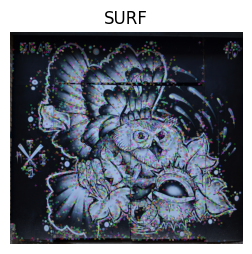

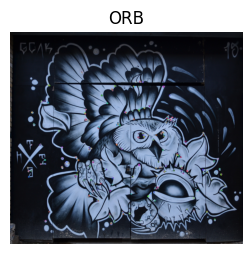

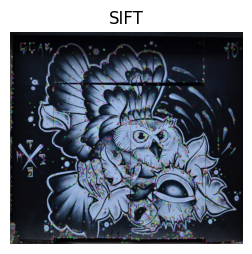

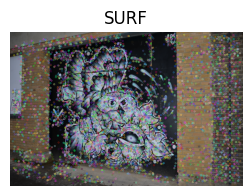

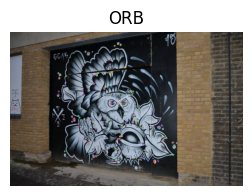

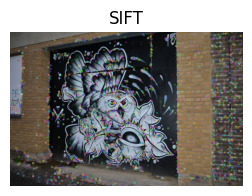

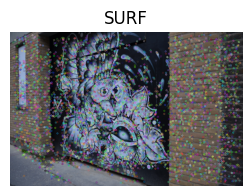

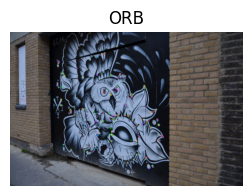

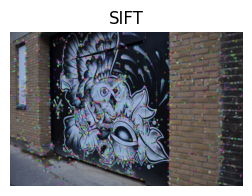

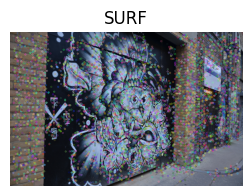

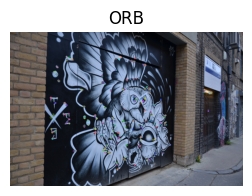

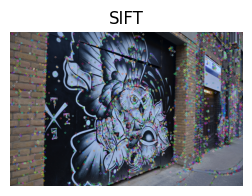

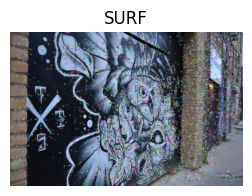

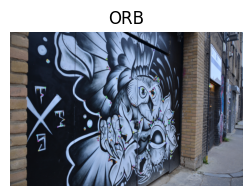

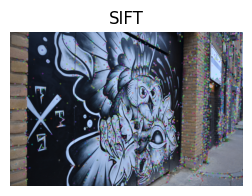

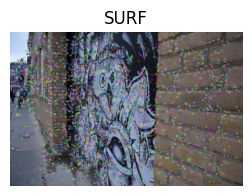

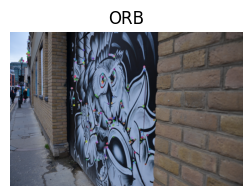

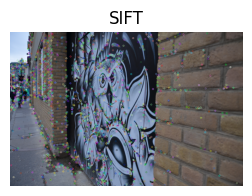

In [136]:
for i in range(len(image_paths)):
    sub_image = cv2.imread(image_paths[i])
    Feature_Extraction(sub_image,method_type='SURF', plot=True);
    Feature_Extraction(sub_image,method_type='ORB', plot=True);
    Feature_Extraction(sub_image,method_type='SIFT', plot=True);

In [137]:
def match_keypoints(kp1, desc1, kp2, desc2, img1, img2, method_type, ratio_threshold=0.75, plot=False):
    
    bf = cv2.BFMatcher()
    matches = bf.match(desc1, desc2)

    # Getting best features
    matches = sorted(matches, key=lambda x: x.distance)

    # Printing the matched features and diplaying them
    if plot:
        net_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
        net_img_rgb = cv2.cvtColor(net_img, cv2.COLOR_BGR2RGB)
        plt.imshow(net_img_rgb)
        plt.axis('off')
        plt.title("Keypoint Matching with "+ method_type)
        plt.show()

    # Storing the points of matched features
    common_points = []
    for match in matches:
        x1y1 = kp1[match.queryIdx].pt
        x2y2 = kp2[match.trainIdx].pt
        feature = list(map(int, list(x1y1) + list(x2y2) + [match.distance]))
        common_points.append(feature)

    return np.array(common_points)



def compute_homography(src_pts, dst_pts):
    n = src_pts.shape[0]
    A = np.zeros((2*n, 8))
    b = np.zeros((2*n, 1))
    for i in range(n):
        x, y = src_pts[i, 0, :]
        u, v = dst_pts[i, 0, :]
        A[2*i, :] = [-x, -y, -1, 0, 0, 0, u*x, u*y]
        A[2*i+1, :] = [0, 0, 0, -x, -y, -1, v*x, v*y]
        b[2*i, 0] = -u
        b[2*i+1, 0] = -v
    h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    h = np.concatenate((h, np.array([[1]])), axis=0)
    H = h.reshape((3, 3))
    return H


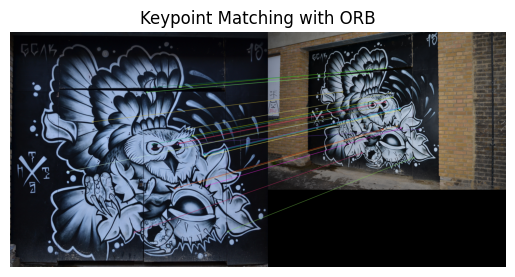

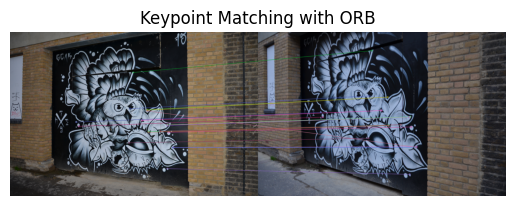

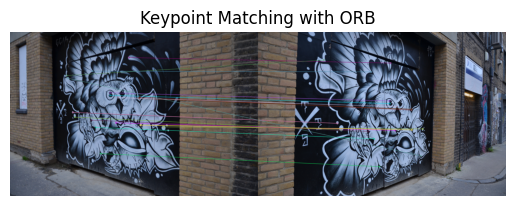

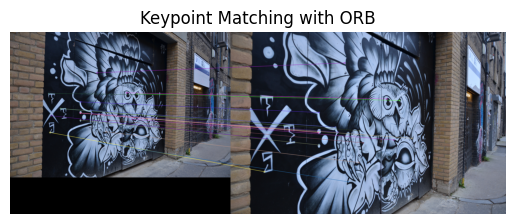

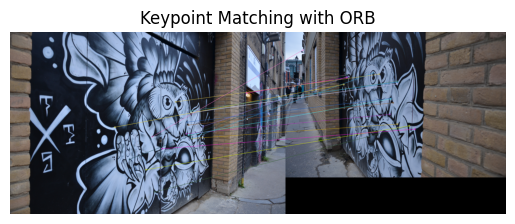

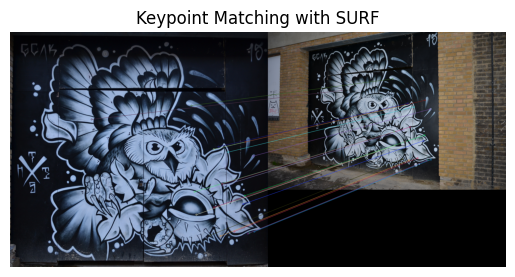

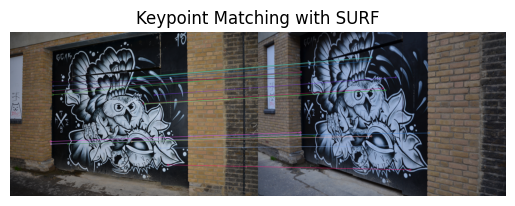

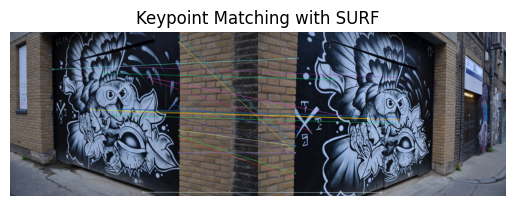

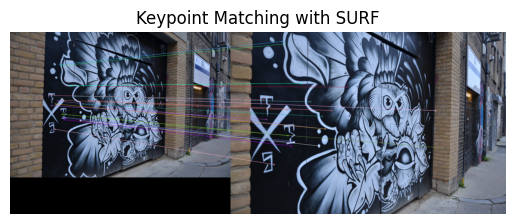

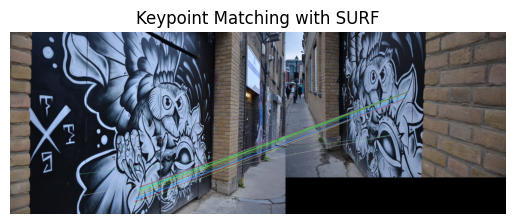

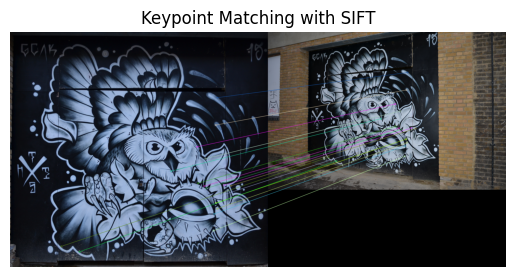

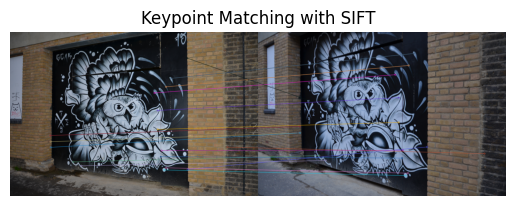

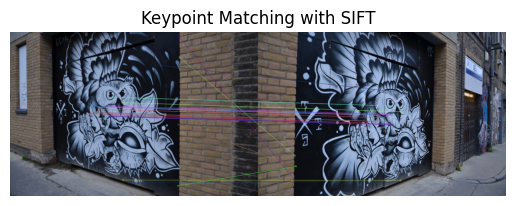

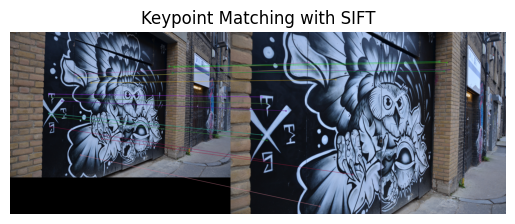

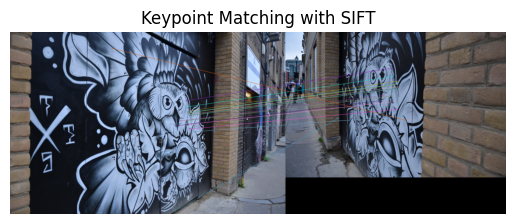

In [138]:
method_types = ['ORB', 'SURF', 'SIFT']
for method_type in method_types:
    for i in range(len(image_paths)-1):
        img1_path = image_paths[i]
        img2_path = image_paths[i+1]
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        #kp is cv2.KeyPoint
        kp1, desc1 = Feature_Extraction(img1, method_type, plot=False)
        kp2, desc2 = Feature_Extraction(img2, method_type, plot=False)

        matches = match_keypoints(kp1, desc1, kp2, desc2,img1, img2, method_type, plot=True);

## PART 3

In [139]:
def homography(matches):

    A = []
    for x, y, u, v, _ in matches:
        A.extend([[x, y, 1, 0, 0, 0, -u*x, -u*y, -u],
                  [0, 0, 0, x, y, 1, -v*x, -v*y, -v]])
    A = np.asarray(A)

    _, _, Vh = np.linalg.svd(A)

    L = Vh[-1, :] / Vh[-1, -1]
    H = L.reshape(3, 3)

    return H

In [140]:
def ransac(matches, n=30, threshold=2, max_iterations=4000):

    inliers_count = 0          
    best_inliers = None    
    best_matches = matches[:n]   


    match_pairs = np.array(list(combinations(best_matches, 4)))

    for matches in match_pairs[:max_iterations]:

        H = homography(matches)

        inliers = []
        count = 0

        
        for feature in best_matches:
            image_1 = np.ones((3, 1))
            image_2 = np.ones((3, 1))
            image_1[:2, 0] = feature[:2]
            image_2[:2, 0] = feature[2:4]

            transformation = np.dot(H, image_1)


            if transformation[-1, 0] != 0:
                transformation = transformation/transformation[-1, 0]

                distance = np.linalg.norm(transformation - image_2)
                if distance < threshold:
                    count += 1
                    inliers.append(feature)

    
        if count > inliers_count:
            inliers_count = count
            best_inliers = inliers

    return homography(best_inliers)

In [141]:
def dmatch_to_np(matches):
    matches_np = np.empty((len(matches), 3))

    for i, match in enumerate(matches):
        matches_np[i, 0] = match.queryIdx
        matches_np[i, 1] = match.trainIdx
        matches_np[i, 2] = match.distance

    return matches_np

In [142]:

img1 = cv2.imread(image_paths[0])
method_types = ['ORB', 'SURF', 'SIFT']
runtimes = {}

for method_type in method_types:
    start_time = time.time()
    print(method_type)
    for i in range(1,len(image_paths)):
        img2_path = image_paths[i]    
        img2 = cv2.imread(img2_path)
        
        kp1, desc1 = Feature_Extraction(img1, method_type, plot=False)
        kp2, desc2 = Feature_Extraction(img2, method_type, plot=False)

        matches = match_keypoints(kp1, desc1, kp2, desc2,img1, img2, method_type, plot=False);
        best_H = ransac(matches)
        
        print('=====================')
        print(f'H_1_{i+1}')
        print(best_H)

    end_time = time.time()
    runtime = end_time - start_time
    runtimes[method_type] = runtime
    print('=====================')
    
print(runtimes)
    

ORB
H_1_2
[[0.31 0.00 176.54]
 [-0.09 0.49 75.86]
 [-0.00 0.00 1.00]]
H_1_3
[[0.15 -0.02 207.40]
 [-0.14 0.47 41.23]
 [-0.00 -0.00 1.00]]
H_1_4
[[1.31 -0.00 88.78]
 [0.36 1.17 -300.58]
 [0.00 0.00 1.00]]
H_1_5
[[2.73 -0.00 -49.36]
 [0.82 2.50 -969.01]
 [0.00 0.00 1.00]]
H_1_6
[[0.05 -1.16 489.21]
 [0.04 -0.94 400.05]
 [0.00 -0.00 1.00]]
SURF
H_1_2
[[0.33 -0.00 169.84]
 [-0.09 0.49 71.01]
 [-0.00 0.00 1.00]]
H_1_3
[[0.05 0.08 226.09]
 [-0.18 0.51 47.29]
 [-0.00 0.00 1.00]]
H_1_4
[[1.34 -0.01 88.60]
 [0.37 1.16 -300.48]
 [0.00 0.00 1.00]]
H_1_5
[[-0.39 -0.69 505.43]
 [-0.57 -0.96 724.62]
 [-0.00 -0.00 1.00]]
H_1_6
[[0.09 -0.85 530.20]
 [0.06 -0.48 292.25]
 [0.00 -0.00 1.00]]
SIFT
H_1_2
[[0.32 -0.00 172.27]
 [-0.09 0.49 74.54]
 [-0.00 0.00 1.00]]
H_1_3
[[0.20 0.01 173.14]
 [-0.13 0.54 11.74]
 [-0.00 0.00 1.00]]
H_1_4
[[1.32 -0.01 92.70]
 [0.37 1.16 -300.79]
 [0.00 0.00 1.00]]
H_1_5
[[2.82 0.03 -66.72]
 [0.84 2.57 -989.24]
 [0.00 0.00 1.00]]
H_1_6
[[-1.12 0.62 567.15]
 [-0.15 0.08 74.29]
 

In [145]:

runtimes_data = [
    {'Algorithm': 'SURF', 'Runtime (s)': runtimes['SURF']},
    {'Algorithm': 'ORB', 'Runtime (s)': runtimes['ORB']},
    {'Algorithm': 'SIFT', 'Runtime (s)': runtimes['SIFT']},   
]


runtime_df = pd.DataFrame(runtimes_data)

runtime_df = runtime_df.sort_values(by='Runtime (s)')

runtime_df

Algorithm  Runtime (s)
1       ORB     6.682186
2      SIFT     7.937368
0      SURF     8.432483

## PART 4